<a href="https://colab.research.google.com/github/crsegerie/bci_competition/blob/master/kaggleBCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook manage to create an online solution to the problem https://www.kaggle.com/c/inria-bci-challenge in 20 minutes. This solution would be ranked 4 in the original competition. This notebook is quite long, we encourage you to find your way around using the table of contents in colab.

Author : Charbel-Raphaël Segerie

## Package Importation

In [ ]:
!pip install pyts 
! pip install mne
!pip install autoviml --quiet

     |████████████████████████████████| 2.5MB 9.0MB/s 
     |████████████████████████████████| 6.9MB 7.3MB/s 
     |████████████████████████████████| 133kB 7.6MB/s 
     |████████████████████████████████| 166.7MB 83kB/s 
     |████████████████████████████████| 133kB 59.3MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 67.3MB 91kB/s 
     |████████████████████████████████| 133kB 50.0MB/s 
     |████████████████████████████████| 358kB 44.7MB/s 
     |████████████████████████████████| 215kB 55.0MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
%cd /content/drive/MyDrive/inria-bci-challenge

/content/drive/MyDrive/inria-bci-challenge


In [ ]:
cc = ["Fz", "Cz", "P3", "Pz", "P4", "PO7", "POz", "P08", "EOG"]

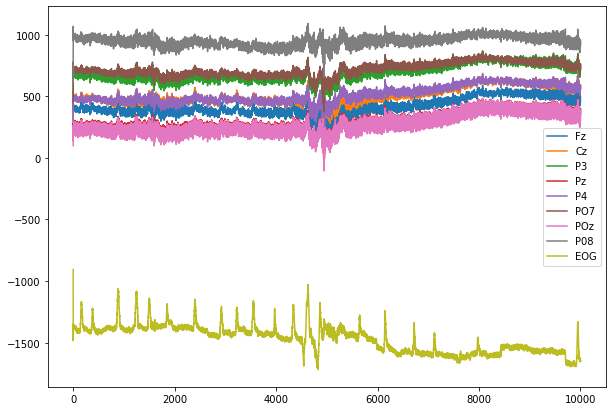

In [ ]:
# 50 secondes of data here
tr1 = pd.read_csv("train/Data_S02_Sess01.csv")
tr1.loc[:10000, cc].plot(figsize=(10,7));

We can see that ocular artifacts, have clearly not been remooved.

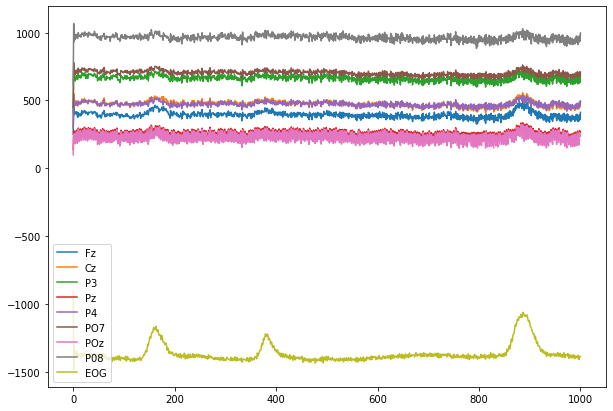

In [ ]:
# 5 seconds of data here
tr1.loc[:1000, cc].plot(figsize=(10,7));

But it seems that cardiac artifacts have already been remooved.

## Import of the original Kaggle Files

https://www.kaggle.com/c/inria-bci-challenge/data

List of files:
- TrainLabels.csv : 5440 rows containing the name of the FeedBack (Subject, Session, FeedBack number, and the label). 70% of the feedback are corrects (Bad feedback is when the selected item is different from the expected item. Good feedback is when the selected item is similar to the expected item.).
- SampleSubmissions is an exemple of what should look like our results.
- ChannelsLocation contains the locations of channels. All channels are EEG channels, except the last one which is an EOG channels (sort of Eye tracking)

TrainLabels.csv: the expected labels  for the training set.

In [ ]:
TrainLabels = pd.read_csv("TrainLabels.csv")
TrainLabels.tail()

IdFeedBack  Prediction
5435  S26_Sess05_FB096           1
5436  S26_Sess05_FB097           0
5437  S26_Sess05_FB098           0
5438  S26_Sess05_FB099           0
5439  S26_Sess05_FB100           1

In [ ]:
TrainLabels.describe()

Prediction
count  5440.000000
mean      0.707721
std       0.454852
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

SampleSubmission.csv: Sample submission file in the correct format

In [ ]:
SampleSubmission = pd.read_csv("SampleSubmission.csv")
SampleSubmission.tail()

IdFeedBack  Prediction
3395  S25_Sess05_FB096           0
3396  S25_Sess05_FB097           0
3397  S25_Sess05_FB098           0
3398  S25_Sess05_FB099           0
3399  S25_Sess05_FB100           0

ChannelsLocation.csv: information for each channel to a topographical representation of multichannel EEG.

In [ ]:
ChannelsLocation = pd.read_csv("ChannelsLocation.csv")
ChannelsLocation.loc[ChannelsLocation["Phi"].isin([-90, 0, 90]), :]

Id Labels  Radius   Phi
10  11     Fz  0.1800   0.0
19  20    FCz  0.0900   0.0
24  25     T7  0.3600 -90.0
25  26     C5  0.2864 -90.0
26  27     C3  0.1800 -90.0
27  28     C1  0.0736 -90.0
28  29     Cz  0.0000  90.0
29  30     C2  0.0736  90.0
30  31     C4  0.1800  90.0
31  32     C6  0.2864  90.0
32  33     T8  0.3600  90.0

T7 on the left side, T8 on the right side.

## Test of winner preprocessing

https://github.com/alexandrebarachant/bci-challenge-ner-2015.

I converted the code from python2 to python 3. That was somewhat painfull, but it worked, I only used his epoched data and his meta information he created.

### Generating the preprocessing (just once)

EEG Signals are bandpass filtered by a 5th order Butterworth filter between 1 and 40 Hz. Then, signals are epoched to take only 1.3 second after the feedback event. The EOG channel is removed prior to any preprocessing.

In [ ]:
# This cell must be used just once in your lifetime.

# %cd ..
# %cd bci-challenge-ner-2015-master
# %cd bci-challenge-ner-2015-master
# %ls
# %cd preproc/
# %run preproc.py

### Importing the preprocessed files of the winner

In [ ]:
%cd /content/drive/My Drive/bci-challenge-ner-2015-master/bci-challenge-ner-2015-master/preproc

/content/drive/My Drive/bci-challenge-ner-2015-master/bci-challenge-ner-2015-master/preproc


In [ ]:
%ls

epochs.npy    meta_leak.npy  Submission.csv   test_meta_leak.npy  y/
infos.npy     meta.npy       test_epochs.npy  test_meta.npy
metadata.csv  preproc.py     test_infos.npy   true_labels.csv


We do not import the leaked information.

In [ ]:
test_meta = np.load("test_meta.npy")
test_infos = np.load("test_infos.npy") # ?
test_epochs = np.load("test_epochs.npy")

meta = np.load("meta.npy")
infos = np.load("infos.npy")
epochs = np.load("epochs.npy")

metadata = pd.read_csv("metadata.csv")

# Kaggle release after the competition. Used only in order to debug my submissions.
true_labels = pd.read_csv("true_labels.csv", header=None)

### Description of the preprocessed files

**meta**

After these 4 steps, a set of Meta Feature are added to the EEG-based features. The basic set of Meta feature is the following :

- Session id : the session number of the current epoch.
- FeedBack : the Feedback count since the beginning of the session.
- Letter : the Letter position in the current word.
- Word : the word count since the beginning of the session.
- FeedBackTot : the feedback count since the first session.
- WordTot : the word count since the first session.
- isLong : was the current word flashed 8 times, i.e. a long sequence of flashes.

For the leak only, two other features are added :
- OnlineErr : 1 if the online Error detection has detected an error (only available in session 5).
- Err Prop : the percentage of errors detected in the session 5.

Here meta.npy only contains only the 7 basic features.

**epochs**

epochs.shape = (5440, 56, 260) # (training feedbacks, EEG channels, times steps)

**infos**

infos.shape = (2, 5440) # infos[0] = feedback, infos[1] = predicted number.

In [ ]:
metadata # contains training and testing examples. 

subject  session  isLong  longProp  onlineErr
0           1        1       0      0.32          0
1           1        1       0      0.32          0
2           1        1       0      0.32          0
3           1        1       0      0.32          0
4           1        1       0      0.32          0
...       ...      ...     ...       ...        ...
8835       26        5       0      0.50          1
8836       26        5       0      0.50          0
8837       26        5       0      0.50          1
8838       26        5       0      0.50          1
8839       26        5       0      0.50          0

[8840 rows x 5 columns]

## Groups

In order to separate the different subject in the train and test set, we use the param group in sklearn.

In [ ]:
_ = np.concatenate((TrainLabels.IdFeedBack, SampleSubmission.IdFeedBack))
_ = np.sort(_)
train_mask = np.isin(_, TrainLabels)

In [ ]:
metadata["train"] = train_mask

In [ ]:
metadata

subject  session  isLong  longProp  onlineErr  train
0           1        1       0      0.32          0  False
1           1        1       0      0.32          0  False
2           1        1       0      0.32          0  False
3           1        1       0      0.32          0  False
4           1        1       0      0.32          0  False
...       ...      ...     ...       ...        ...    ...
8835       26        5       0      0.50          1   True
8836       26        5       0      0.50          0   True
8837       26        5       0      0.50          1   True
8838       26        5       0      0.50          1   True
8839       26        5       0      0.50          0   True

[8840 rows x 6 columns]

In [ ]:
train_subjects = metadata.groupby(["subject"])["train"].mean()
train_subjects = train_subjects[train_subjects].index
train_subjects

Int64Index([2, 6, 7, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26], dtype='int64', name='subject')

In [ ]:
groups = metadata.subject[train_mask]

## Univariate analysis

In [ ]:
columns_meta = ["session", "Feedback", "Letter", "Word", "feedbacktot", "wordtot", "islong"]
df_meta = pd.DataFrame(meta, columns=columns_meta)
df_meta["pred"] = infos[0]
df_meta.corr()[["pred"]]

pred
session     -0.128355
Feedback    -0.060973
Letter      -0.022292
Word        -0.059727
feedbacktot -0.130285
wordtot     -0.129977
islong       0.171839
pred         1.000000

Seems legit. When the word is long, the prediction is better.

In [ ]:
df_meta

session  Feedback  Letter  Word  feedbacktot  wordtot  islong  pred
0         1.0       0.0     1.0   1.0          0.0      1.0     0.0   1.0
1         1.0       1.0     2.0   1.0          1.0      1.0     0.0   1.0
2         1.0       2.0     3.0   1.0          2.0      1.0     0.0   0.0
3         1.0       3.0     4.0   1.0          3.0      1.0     0.0   0.0
4         1.0       4.0     5.0   1.0          4.0      1.0     0.0   1.0
...       ...       ...     ...   ...          ...      ...     ...   ...
5435      5.0      95.0     1.0  20.0        335.0     68.0     0.0   1.0
5436      5.0      96.0     2.0  20.0        336.0     68.0     0.0   0.0
5437      5.0      97.0     3.0  20.0        337.0     68.0     0.0   0.0
5438      5.0      98.0     4.0  20.0        338.0     68.0     0.0   0.0
5439      5.0      99.0     5.0  20.0        339.0     68.0     0.0   1.0

[5440 rows x 8 columns]

## Visualisation of epoch data

The aim here is to check the groups and to visualise the difference between good and bad decision.

freq = 200.0. 1.3s extracted for each event.

In [ ]:
epochs.shape

(5440, 56, 260)

In [ ]:
train_metadata = metadata[metadata.train].copy()
train_metadata.reset_index(inplace=True)
train_metadata['prediction'] = infos[0]

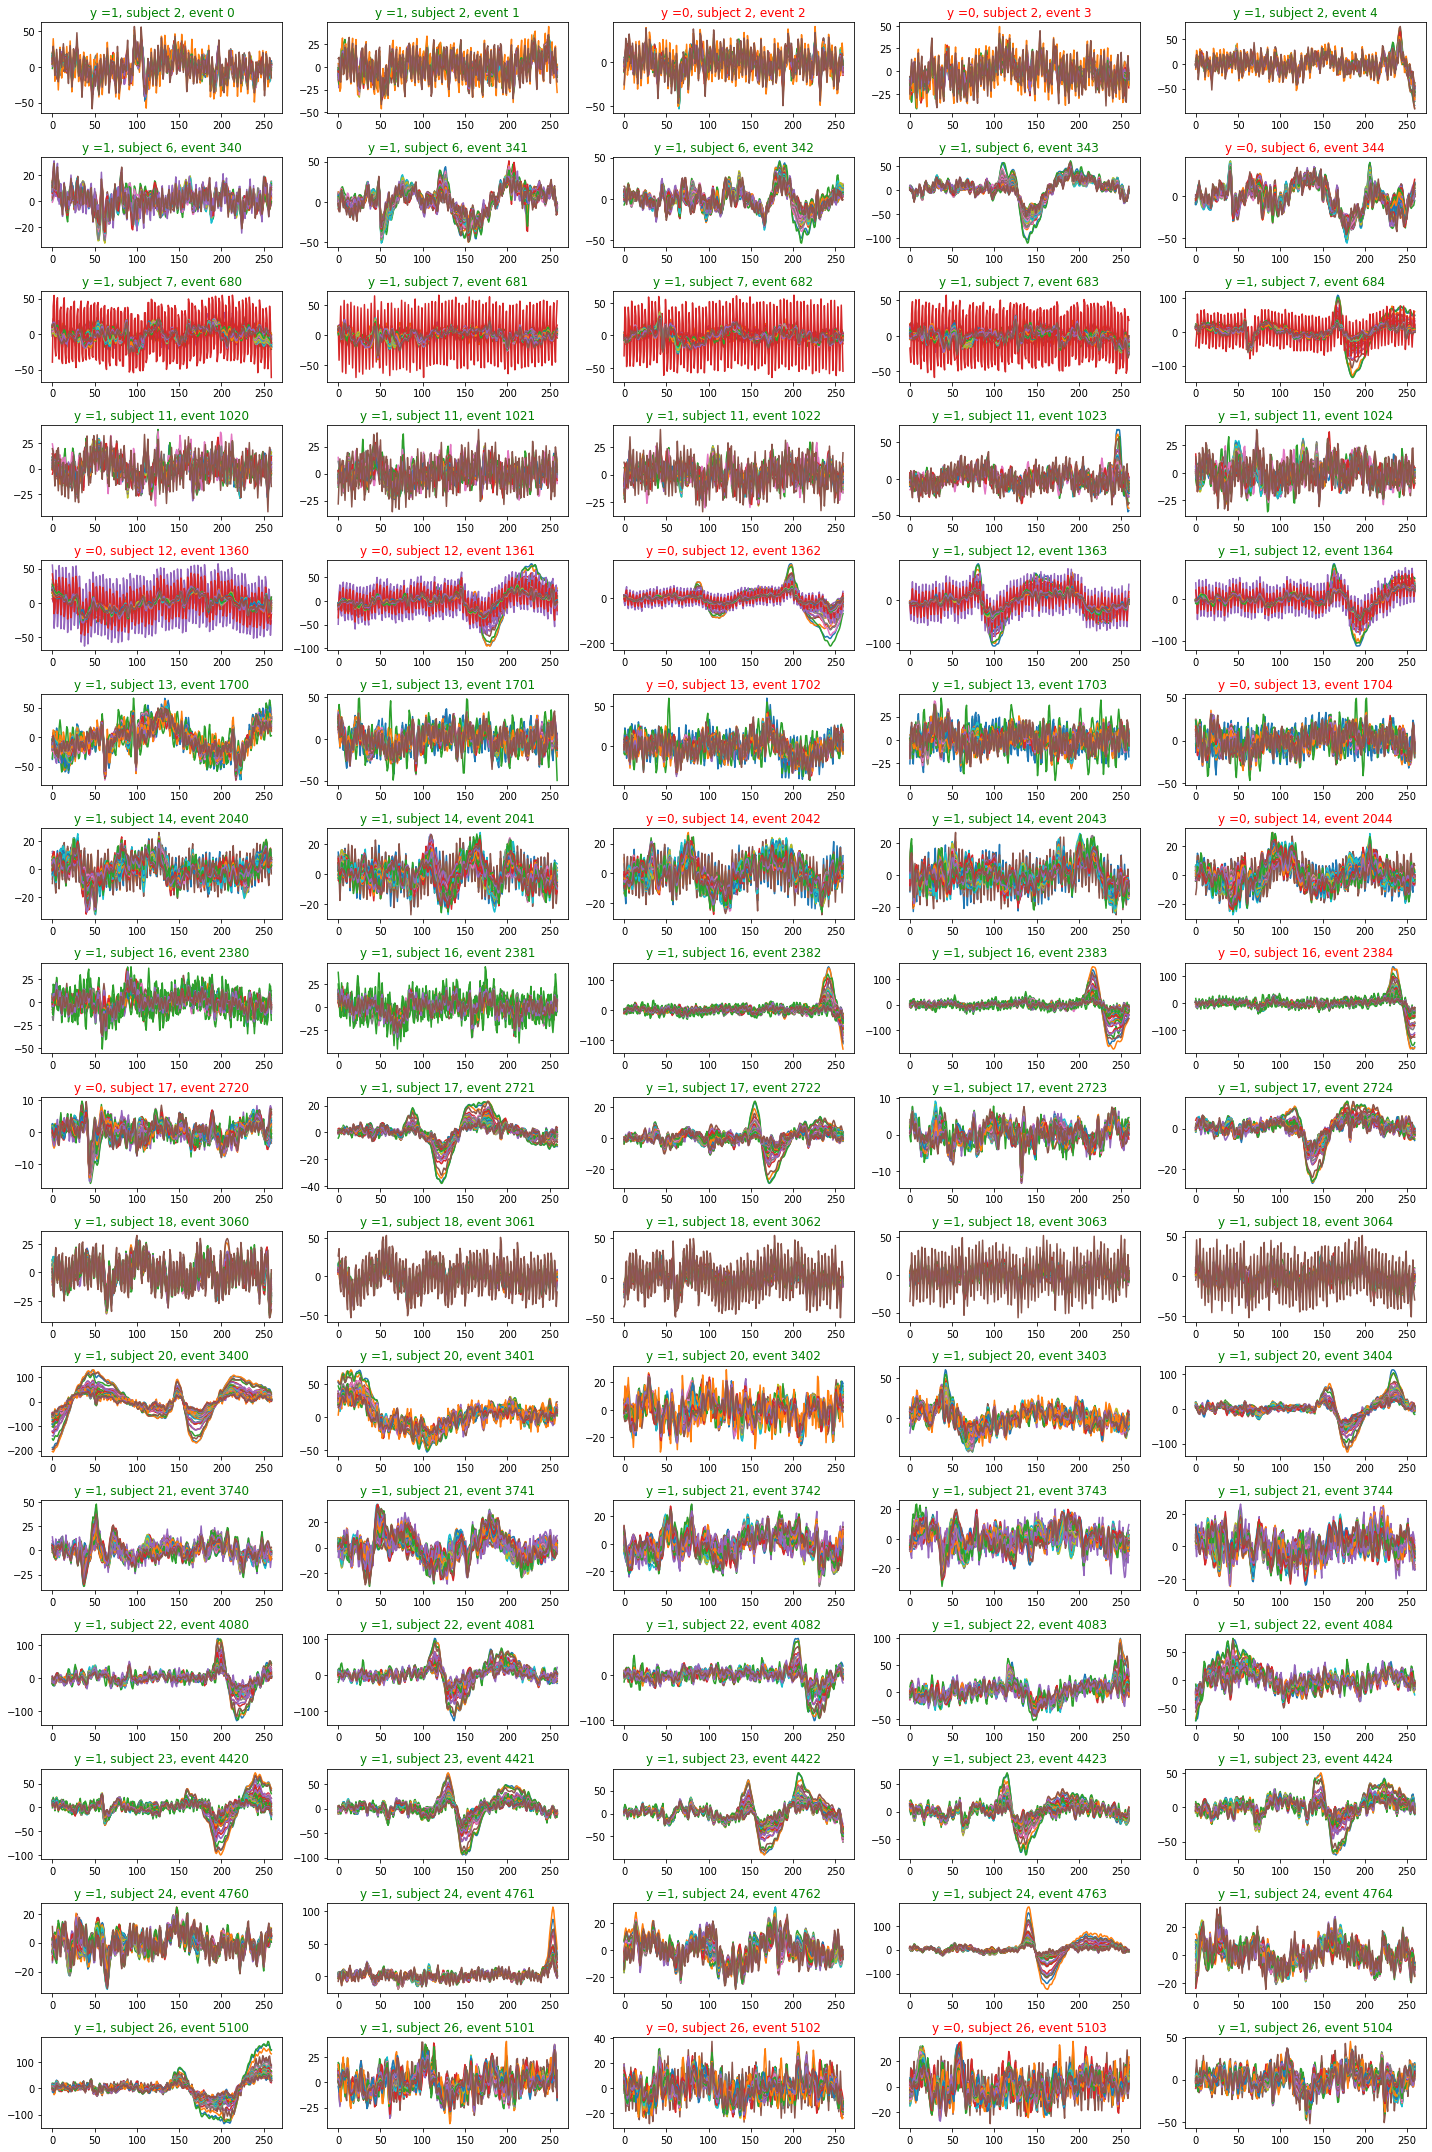

In [ ]:
n_col = 5
fig, axs = plt.subplots(len(train_subjects), n_col, figsize=(20, 30))

for i_s, s in tqdm(enumerate(train_subjects), total=len(train_subjects)):
    subject_metadata = train_metadata[train_metadata.subject == s].copy()
    # indices = np.random.choice(np.arange(len(subject_metadata)), 10)
    indices = subject_metadata.index[:n_col]
    for i_c, i in enumerate(indices):
        axs[i_s, i_c].plot(epochs[i].T)
        pred = int(infos[0, i])
        title = f"y ={pred}, subject {s}, event {i}"
        axs[i_s, i_c].set_title(title, color="green" if pred else "red")

fig.tight_layout()

It seems there are bad channels, but according to mne documentation, bad channel removing is not necessary for a machine learning pipeline. We will need to filter higher order frequency.

### Filter freq (<12Hz) + extract PSD

Not setting metadata
Not setting metadata
5440 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-52-640542085260>:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne_epochs.plot_psd()


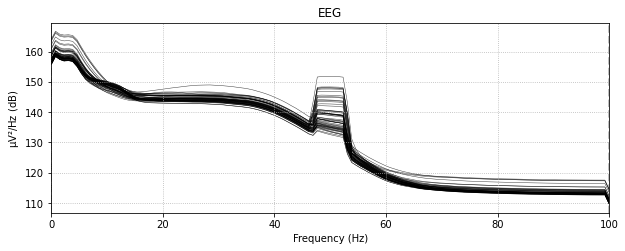

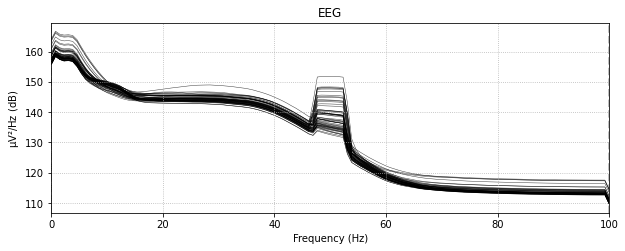

In [ ]:
mne_epochs = mne.EpochsArray(epochs, mne_info, events=None, 
                                tmin=0, event_id=None, reject=None,
                    flat=None, reject_tmin=None, reject_tmax=None,
                    baseline=None, proj=True, on_missing='raise',
                    metadata=None, selection=None, verbose=None)
mne_epochs.plot_psd()

In [ ]:
import mne
from mne.time_frequency import psd_welch

# This cell takes something like 10 minutes to run.

mne_info = mne.create_info(ch_names=list(ChannelsLocation.Labels.values),
                        sfreq=200, ch_types=['eeg']*56, verbose=None, )

def filter(epochs):
    """ Compute the PSD and then low pass filter.
    """
    mne_epochs = mne.EpochsArray(epochs, mne_info, events=None, 
                                tmin=0, event_id=None, reject=None,
                    flat=None, reject_tmin=None, reject_tmax=None,
                    baseline=None, proj=True, on_missing='raise',
                    metadata=None, selection=None, verbose=None)

    psd = psd_welch(mne_epochs, fmin=0, fmax=50, tmin=None, tmax=None,
                    n_fft=256, n_overlap=0, n_per_seg=None, picks=None, 
                    proj=False, n_jobs=1, reject_by_annotation=True, 
                                            average='mean', window='hamming',
                                            verbose=None)
    psd_epochs = np.mean(psd[0], axis=1)
    names_freq = [str(round(f, 3)) for f in psd[1]]
    
    """"
    psd[0].shape
    (5440, 56, 65)
    ipdb> psd[1].shape
    (65,)
    """

    # 12 Hz is a good frequency according to
    mne_epochs.filter(l_freq=1, h_freq=12)

    filtered_epochs = mne_epochs.get_data()
    return filtered_epochs, psd_epochs, names_freq, mne_epochs

filtered_epochs, psd_epochs, names_freq, mne_epochs = filter(epochs)
filtered_test_epochs, psd_test_epochs, names_freq_test, mne_epochs_test = filter(test_epochs)
names_freq == names_freq_test

Not setting metadata
Not setting metadata
5440 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Effective window size : 1.280 (s)
Setting up band-pass filter from 1 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 661 samples (3.305 sec)



<ipython-input-23-66fb9dc454d7>:34: RuntimeWarning: filter_length (661) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  mne_epochs.filter(l_freq=1, h_freq=12)


Not setting metadata
Not setting metadata
3400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Effective window size : 1.280 (s)
Setting up band-pass filter from 1 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 661 samples (3.305 sec)



<ipython-input-23-66fb9dc454d7>:34: RuntimeWarning: filter_length (661) is longer than the signal (260), distortion is likely. Reduce filter length or filter a longer signal.
  mne_epochs.filter(l_freq=1, h_freq=12)


True

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-25-d587b1b45b8c>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne_epochs.plot_psd()


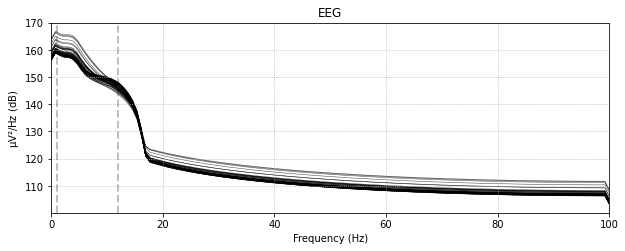

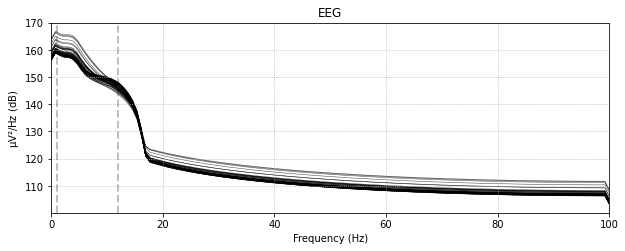

In [ ]:
mne_epochs.plot_psd()

### Subjects Caracteristics.

In [ ]:
subjects_data = train_metadata.groupby(["prediction", "subject"])[["session"]].count()
subjects_data.reset_index(inplace=True)
_ = subjects_data.loc[subjects_data.prediction == 1]

# There are 340 events for each subject.
ratio_good_pred = _.sort_values("session").set_index("subject")[["session"]] /340
ratio_good_pred

session
subject          
13       0.523529
26       0.532353
12       0.555882
16       0.620588
14       0.632353
2        0.647059
23       0.650000
11       0.661765
17       0.664706
20       0.694118
24       0.702941
18       0.767647
7        0.902941
21       0.917647
22       0.920588
6        0.929412

- subjects 5, 21, 22, 6 are generally well predicted by the BCI.
- With the subjects 13, the BCI struggle a bit. Half of the characters on the screen are not predicted correcly. But it's still well better than random guessing (52% >> 1/24 letters)


### Evoked Visu by subject

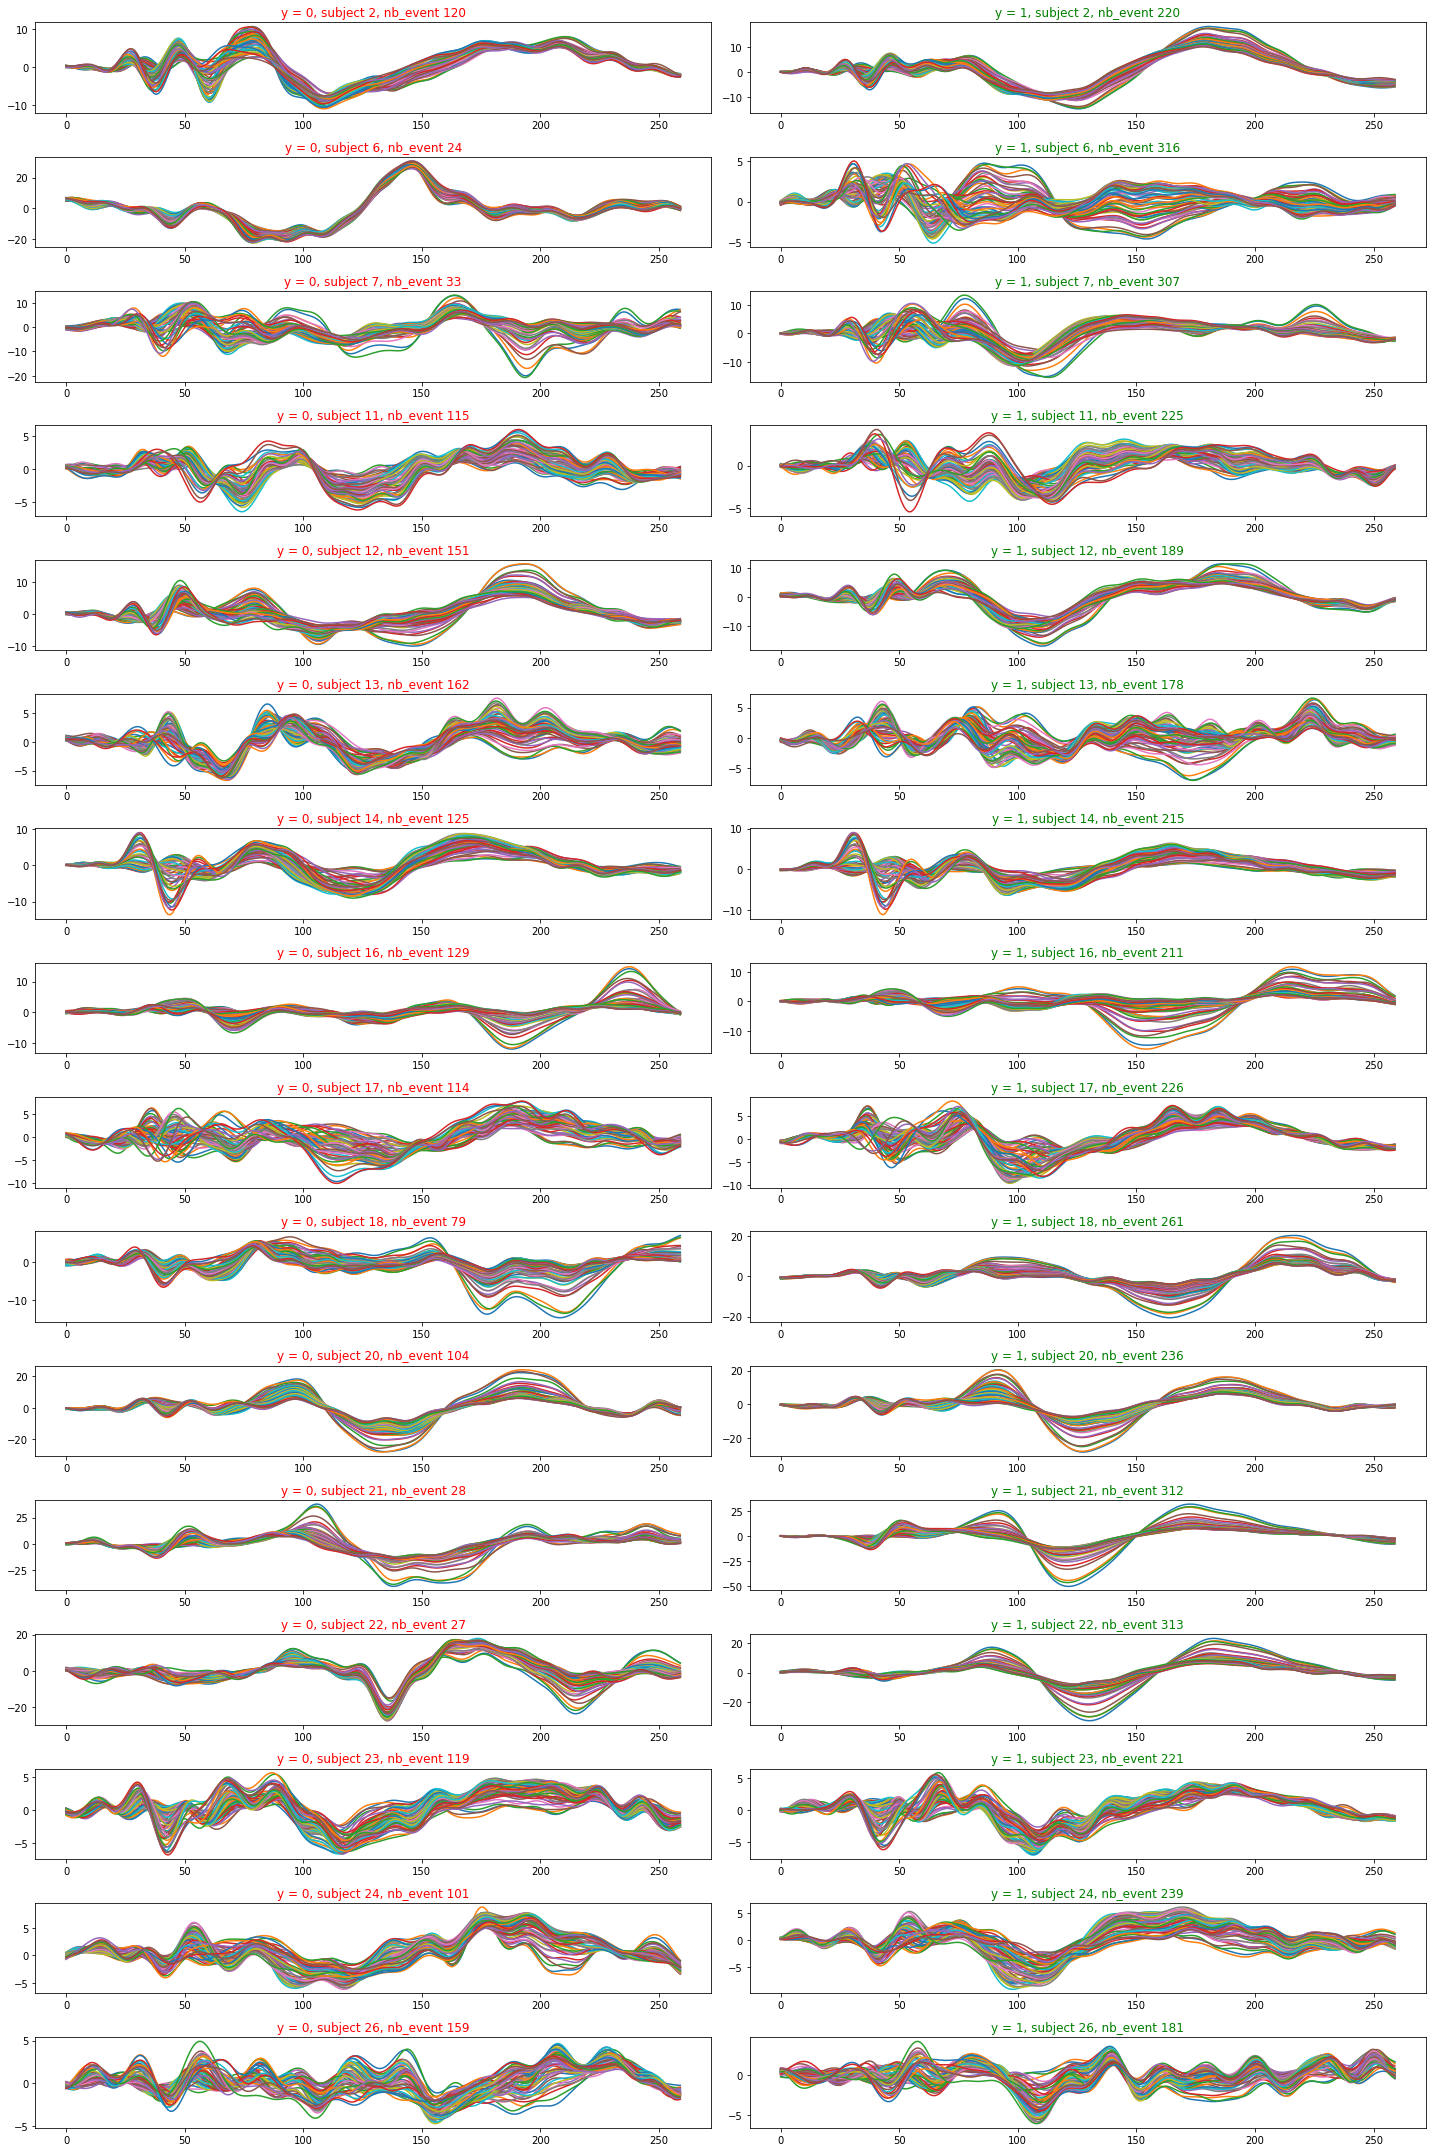

In [ ]:
n_col = 2
fig, axs = plt.subplots(len(train_subjects), n_col, figsize=(20, 30))

ls_evoked = np.empty((len(train_subjects), 2, 56, 260))
for i_s, s in tqdm(enumerate(train_subjects), total=len(train_subjects)):

    for y in [0, 1]:
        subject_metadata = train_metadata[
                                          (train_metadata.subject == s)
                                          &(train_metadata.prediction == y)
                                          ].copy()
        indices = subject_metadata.index
        evoked = np.mean(epochs[indices], axis=0)
        ls_evoked[i_s, y] = evoked
        axs[i_s, y].plot(evoked.T)
        title = f"y = {y}, subject {s}, nb_event {len(indices)}"
        axs[i_s, y].set_title(title, color="green" if y else "red")

fig.tight_layout()

### Patern matching : Grand total Evoked visu

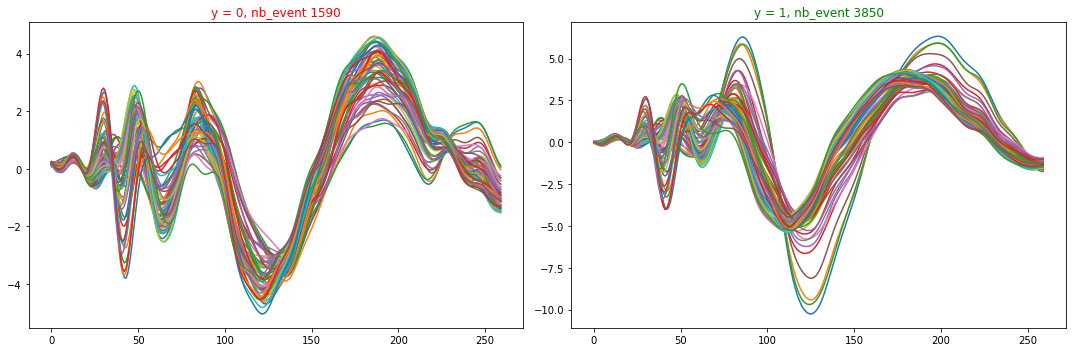

In [ ]:
n_col = 2
fig, axs = plt.subplots(1, n_col, figsize=(15, 5))

grand_evoked = np.empty((2, epochs.shape[1], epochs.shape[2]))
for y in [0, 1]:
    subject_metadata = train_metadata[(train_metadata.prediction == y)].copy()
    indices = subject_metadata.index
    evoked = np.mean(epochs[indices], axis=0)
    grand_evoked[y] = evoked
    axs[y].plot(evoked.T)
    title = f"y = {y}, nb_event {len(indices)}"
    axs[y].set_title(title, color="green" if y else "red")

fig.tight_layout()

## Experiments with Patern Matching

We look at the correlation with the mean of each class, subject ?

In [ ]:
for i_s, s in tqdm(enumerate(train_subjects), total=len(train_subjects)):
    subject_metadata = train_metadata[train_metadata.subject == s].copy()
    # indices = np.random.choice(np.arange(len(subject_metadata)), 10)
    indices = subject_metadata.index[:]
    for i_c, i in enumerate(indices):
        for y in [0, 1]:
            a, b = epochs[i], ls_evoked[i_s, y]
            a, b = np.mean(a, axis=0), np.mean(b, axis=0)

            b = grand_evoked[y]
            # a, b = a.flatten(), b.flatten()
            cor = np.corrcoef(a, b)[1,0]

            train_metadata.loc[i, f"corr{y}"] = cor

for index, row in train_metadata.iterrows():
    train_metadata.loc[index, "pred_corr"] = np.argmax(row[["corr0", "corr1"]])
train_metadata

index  subject  session  ...     corr0     corr1  pred_corr
0       340        2        1  ... -0.333228 -0.282791        1.0
1       341        2        1  ...  0.052989 -0.208369        0.0
2       342        2        1  ...  0.124820 -0.053596        0.0
3       343        2        1  ... -0.111147 -0.240757        0.0
4       344        2        1  ...  0.140773  0.140040        0.0
...     ...      ...      ...  ...       ...       ...        ...
5435   8835       26        5  ... -0.187853 -0.158652        1.0
5436   8836       26        5  ...  0.127564  0.096573        0.0
5437   8837       26        5  ... -0.000393  0.168980        1.0
5438   8838       26        5  ... -0.172778 -0.044378        1.0
5439   8839       26        5  ...  0.288087  0.425072        1.0

[5440 rows x 11 columns]

In [ ]:
np.mean(train_metadata.pred_corr == infos[0])

0.6042279411764706

Different accuracies : 

Compare epoch with the mean of the individual :

Cutoff = 50 Hz
- 0.6503676470588236 = mean 56 channels.
- 0.67775735 = without mean : It seems there is a common denominator between all the series.

Cutoff = 12 Hz
- 0.639 Mean of the 56 channels
- 0.661 Without mean

Compare with the grand average epochs + cuttof 12Hz
- 0.60422794 without mean

In [ ]:
np.corrcoef(a, b).shape

(57, 57)

### Patern Matching Features

In [ ]:
def compute_cor(epochs, meta):
    """ Copute correlation with grand evoked epochs and update meta with corr
    """
    cor = np.empty((len(epochs), 7))
    for i in tqdm(range(len(epochs))):
        a = np.mean(epochs[i], axis=0)
        for y in [0, 1]:
            b = np.mean(grand_evoked[y], axis=0)
            cor[i, y] = np.corrcoef(a, b)[1,0]
            cor[i, 4+y] = np.mean(np.abs(a-b))

    cor[:, 2] = cor[:, 1] - cor[:, 0]
    cor[:, 3] = np.positive(cor[:, 2])
    cor[:, 6] = cor[:, 5] / cor[:, 4]

    epochs_var = np.std(epochs, axis=1)[:, ::2]
    epochs_max = np.max(epochs, axis=1)[:, ::2]
    epochs_min = np.min(epochs, axis=1)[:, ::2]
    
    meta = np.concatenate((meta, cor, epochs_var, epochs_max, epochs_min), axis=1)
    print(cor)
    return meta
columns_meta_cor = columns_meta + ["cor0", "cor1", "dif", "bool_dif", "eucl0", "eucl1", "DivEucl"]
columns_meta_cor = columns_meta_cor + [f"std{str(i)}" for i in range(0, epochs.shape[2], 2)]
columns_meta_cor = columns_meta_cor + [f"max{str(i)}" for i in range(0, epochs.shape[2], 2)]
columns_meta_cor = columns_meta_cor + [f"min{str(i)}" for i in range(0, epochs.shape[2], 2)]

meta_cor = compute_cor(epochs, meta)
test_meta_cor = compute_cor(test_epochs, test_meta)


[[-0.2364453  -0.17631551  0.06012978 ...  7.34801869  7.4313232
   1.011337  ]
 [-0.32172988 -0.41189062 -0.09016074 ...  6.49527405  6.90529751
   1.06312643]
 [-0.04338045 -0.18631845 -0.142938   ...  5.12557633  5.41435391
   1.05634051]
 ...
 [ 0.1099618   0.15315059  0.04318879 ...  7.32200432  7.30196128
   0.99726263]
 [-0.03064194  0.14642816  0.1770701  ...  7.64817475  7.47455474
   0.97729916]
 [ 0.26469019  0.31517584  0.05048564 ...  7.2160381   7.14939053
   0.99076397]]



[[ 4.60467790e-01  4.03643232e-01 -5.68245583e-02 ...  8.66842210e+00
   8.60577564e+00  9.92773026e-01]
 [-3.11555000e-01 -3.22178592e-01 -1.06235923e-02 ...  8.12739613e+00
   8.39272473e+00  1.03264620e+00]
 [ 4.83805587e-01  3.49103822e-01 -1.34701765e-01 ...  1.14543219e+01
   1.15332384e+01  1.00688968e+00]
 ...
 [ 2.34838646e-01  2.73449435e-01  3.86107893e-02 ...  3.39562968e+00
   3.41156719e+00  1.00469354e+00]
 [ 3.03093829e-01  4.53023424e-01  1.49929594e-01 ...  7.37767428e+00
   6.89424743e+00  9.34474357e-01]
 [ 2.90223495e-01  1.50417829e-01 -1.39805666e-01 ...  3.91924407e+00
   4.02957030e+00  1.02814988e+00]]


## How to SubSample ? Visualization of our subsampling params.

On regarde à quoi ressemble la serie temporelle. Et de manière visuelle, on essaye d'enlever des channels et de faire du subsampling.

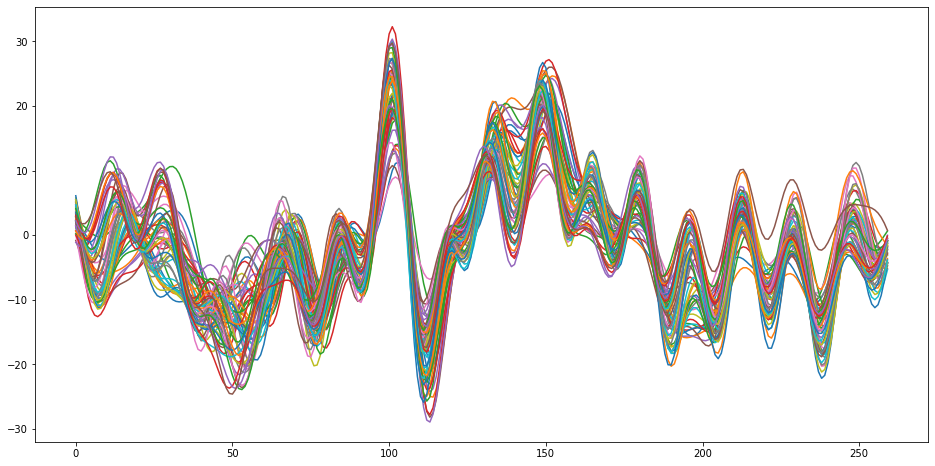

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(filtered_epochs[0,::1, ::1].T);

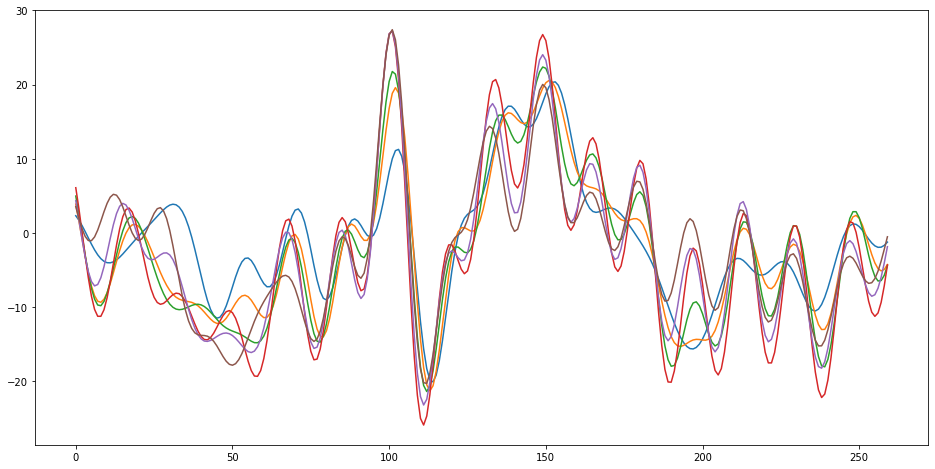

In [ ]:
spatialSampling = 10
plt.figure(figsize=(16, 8))
plt.plot(filtered_epochs[0,::spatialSampling, ::].T);

Divided the dimension by 30 remaining dimensions : 522


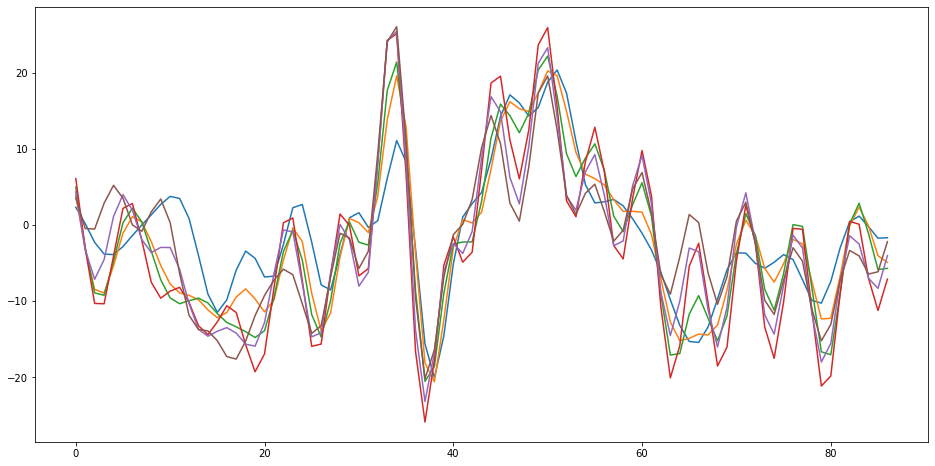

In [ ]:
timeSampling = 3
plt.figure(figsize=(16, 8))
subSampled = filtered_epochs[0,::spatialSampling, ::timeSampling]
print(f"Divided the dimension by {spatialSampling*timeSampling}", 
      f"remaining dimensions : {len(subSampled.flatten())}")
plt.plot(subSampled.T);

It remains 500 dimensions, but we have 5000 epochs. We can still make another feature selection round and we will be good.

### Grand average evoked subsampled

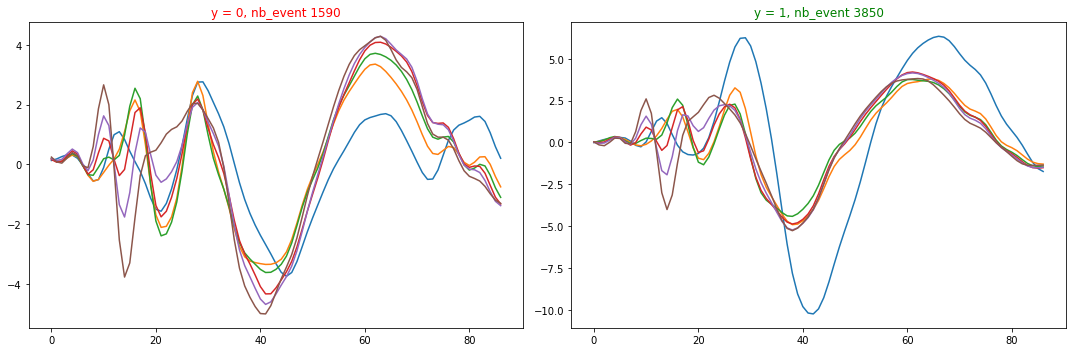

In [ ]:
n_col = 2
fig, axs = plt.subplots(1, n_col, figsize=(15, 5))

for y in [0, 1]:
    subject_metadata = train_metadata[(train_metadata.prediction == y)].copy()
    indices = subject_metadata.index
    evoked = np.mean(epochs[indices], axis=0)
    subSampled = evoked[::spatialSampling, ::timeSampling]
    axs[y].plot(subSampled.T)
    title = f"y = {y}, nb_event {len(indices)}"
    axs[y].set_title(title, color="green" if y else "red")

fig.tight_layout()

## Predict

- 0.7077205 without meta_data
- 0.751 with meta data.

####train test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from  sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import FastICA


names_feat = None
def subsample_and_concat(filtered_epochs, meta, psd_epochs, subsample=True):
    if subsample:
        subSampled = filtered_epochs[:,::spatialSampling, ::timeSampling]
        subSampled = subSampled.reshape((subSampled.shape[0], -1))
    else:
        subSampled = np.mean(filtered_epochs, axis=1)
    X = np.concatenate((meta, subSampled, psd_epochs), axis=1)

    names_subSampled = [f"SubS+{str(int(i))}" for i in range(len(subSampled[0]))]
    global names_feat
    names_feat = columns_meta_cor + names_subSampled + names_freq
    assert len(names_feat) == X.shape[1]
    return X

X, y = subsample_and_concat(filtered_epochs, meta_cor, psd_epochs), infos[0]
print(X.shape, y.shape)

def train_test_split(X, y, groups):
    train_indx, test_indx = next(
        GroupShuffleSplit().split(X, y, groups)
    )
    print("Subjects in Train:", train_metadata.loc[train_indx].subject.unique())
    print("all subjects available:", train_metadata.subject.unique())

    X_train, X_test, y_train, y_test = \
        X[train_indx], X[test_indx], y[train_indx], y[test_indx]
    return X_train, X_test, y_train, y_test, train_indx, test_indx

X_train, X_test, y_train, y_test, train_indx, test_indx = train_test_split(X, y, groups)

(5440, 991) (5440,)
Subjects in Train: [ 7 11 12 13 14 16 17 18 20 21 23 26]
all subjects available: [ 2  6  7 11 12 13 14 16 17 18 20 21 22 23 24 26]


####classification choice

In [ ]:
##############  Sklearn Classics #########################
# clf = LogisticRegressionCV(cv=5,penalty="l2",max_iter=10000, verbose=1,n_jobs=-1)
# clf = MLPClassifier()
clf = RandomForestClassifier(n_estimators=1000)
# clf = KNeighborsClassifier(n_neighbors=10, )


################ PYTS ####################################
# from pyts.classification import KNeighborsClassifier, SAXVSM
# from pyts.transformation import WEASEL, ROCKET
# # clf = KNeighborsClassifier(metric='dtw') 
# weasel = WEASEL(word_size=4, window_sizes=np.arange(5, 149))
# logistic = LogisticRegressionCV()
# clf = make_pipeline(weasel, logistic)


pipe = make_pipeline(StandardScaler(),
                     # FastICA(n_components=150),
                     SelectKBest(f_classif, k=100),
                     # PolynomialFeatures(),
                     clf)

pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=100)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1000))])

In [ ]:
################# TRAINING ##############################
print(X_train.shape)
pipe.fit(X_train, y_train)

(4080, 991)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=100)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1000))])

In [ ]:
def class_balance(y):
    a = np.mean(y == y[0])
    return max(a, 1-a)

def pretty_results(X_train, X_test, y_train, y_test, pipe):
    df_results = pd.DataFrame(index=["class_balance", "accuracy", "AUC"],
                            columns=["train", "test"])

    for i, (X, y) in enumerate([[X_train, y_train], [X_test, y_test]]):
        df_results.iloc[0, i] = class_balance(y)
        df_results.iloc[1, i] = pipe.score(X, y)
        df_results.iloc[2, i] = roc_auc_score(y, pipe.predict_proba(X)[:, 1])

    return df_results

pretty_results(X_train, X_test, y_train, y_test, pipe)

train      test
class_balance  0.676961       0.8
accuracy              1  0.778676
AUC                   1  0.679503

### Auto scikit

In [ ]:
from autoviml.Auto_ViML import Auto_ViML
def create_df_auto_scikit(filtered_epochs, meta, psd_epochs, train=True):
    X, y = subsample_and_concat(filtered_epochs, meta, psd_epochs), infos[0]
    df_auto_scikit = pd.DataFrame(X, columns=names_feat)
    
    if train:
        df_auto_scikit["y"] = y
    return df_auto_scikit

df_auto_scikit = create_df_auto_scikit(filtered_epochs, meta_cor, psd_epochs)
df_auto_scikit_test = create_df_auto_scikit(filtered_test_epochs, test_meta_cor, 
                                            psd_test_epochs, train=False)

Imported Auto_ViML version: 0.1.681. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            

Imported Auto_NLP version: 0.0.45.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (4080, 992)
    Training Set Memory Usage = 30.91 MB
Test Set Shape = (1360, 992)
    Test Set Memory Usage = 10.30 MB
Single_Label Target: ['y']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
         0.0:    1318  ->   32.3%
         1.0:    2762  ->   67.7%
    Target y is already numeric. No transformation done.
Alert! Rare Class is not 1 but 0 in this data set
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 4080 rows, 991 cols
Too many columns to print
    Numeric Columns: ['Feedback', 'Word', 'feedbacktot', 'wordtot', 'cor0', 'cor1', 'dif', 'bool_dif', 'eucl0', 'eucl1', 'DivEucl', 'std0', 'std2', 'std4', 'std6', 'std8', 'std10', 'std12', 'std14', 'std16', 'std18', 'std20', 'std

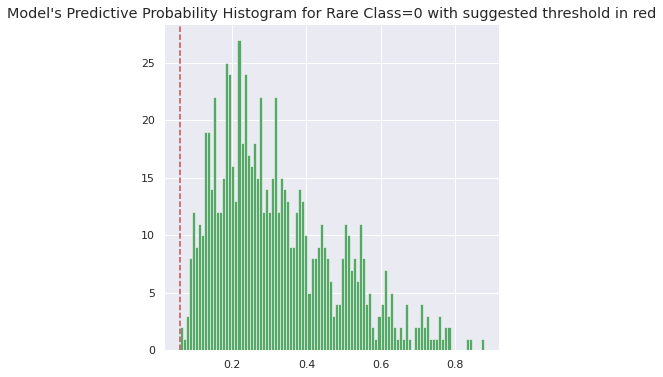

    Using threshold=0.5. However, 0.058 provides better F1=0.81 for rare class...
########################################################
XGBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 32.4%
Balanced Accuracy = 60.63% with Threshold = 0.50
Confusion Matrix:
[[ 81 183]
 [ 52 500]]
              precision    recall  f1-score   support

           0       0.61      0.31      0.41       264
           1       0.73      0.91      0.81       552

    accuracy                           0.71       816
   macro avg       0.67      0.61      0.61       816
weighted avg       0.69      0.71      0.68       816

Balanced Accuracy = 50.00% with Threshold = 0.06
Confusion Matrix:
[[264   0]
 [552   0]]
              precision    recall  f1-score   support

           0       0.32      1.00      0.49       264
           1       0.00      0.00      0.00       552

    accuracy                           0.32       816
   macro avg       0.16      0.50      0.24

After multiple models, Ensemble Model Results:
Binary Class Model Metrics Report
#####################################################
    Accuracy          = 32.4%
    Balanced Accuracy = 50.0%
    Precision         = 0.0%
    Average Precision = 16.2%
    Recall            = 0.0%
    F1 Score          = 0.0%
#####################################################
              precision    recall  f1-score   support

           0       0.32      1.00      0.49       264
           1       0.00      0.00      0.00       552

    accuracy                           0.32       816
   macro avg       0.16      0.50      0.24       816
weighted avg       0.10      0.32      0.16       816

[[264   0]
 [552   0]]
#############################################################################
Single Model is better than Ensembling Models for this data set.


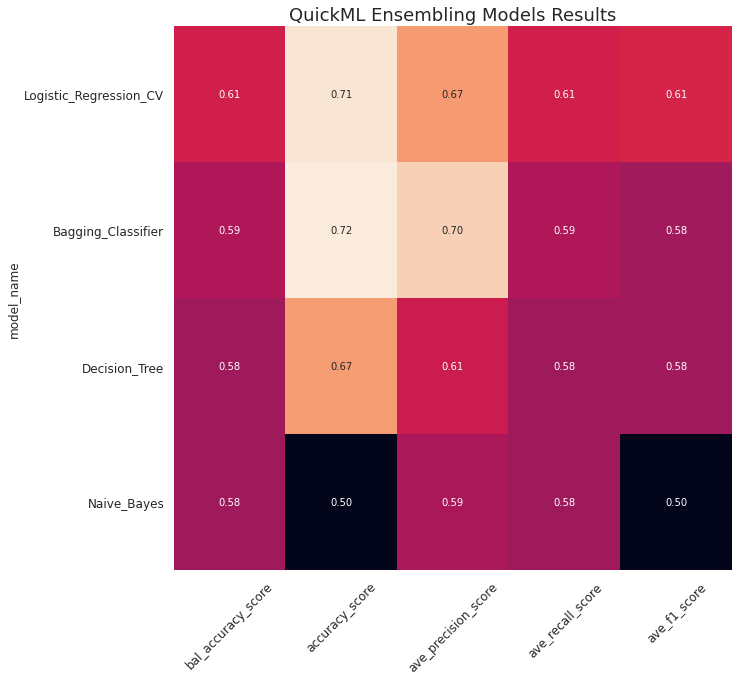

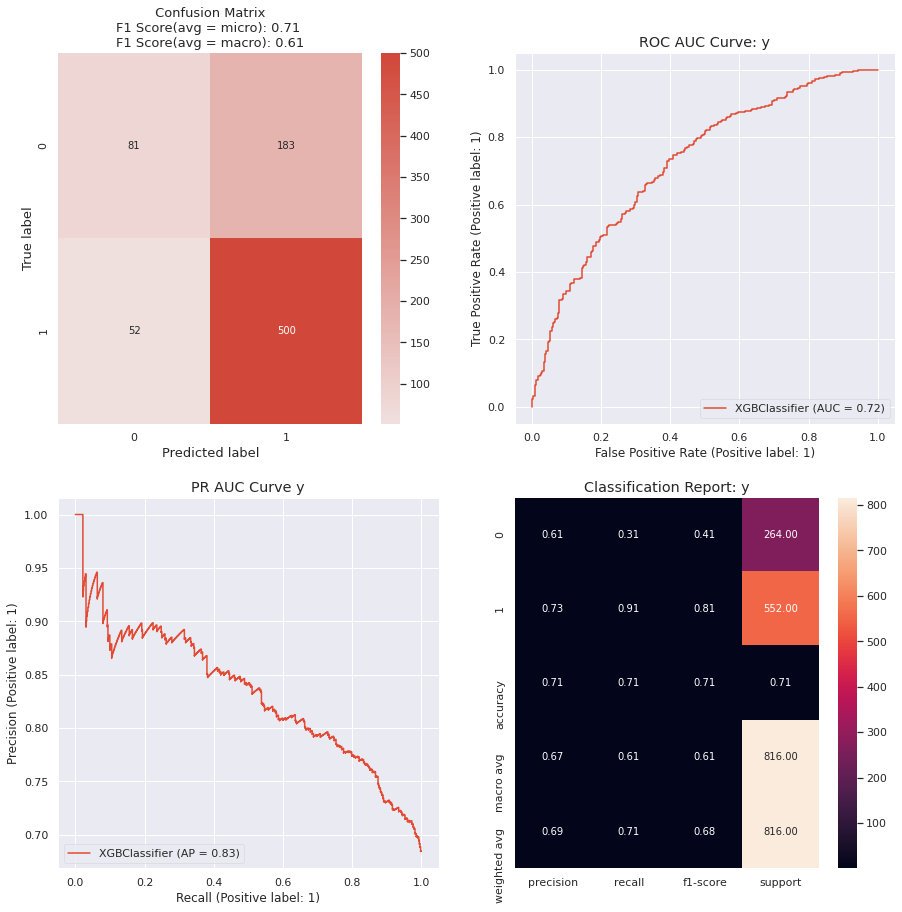

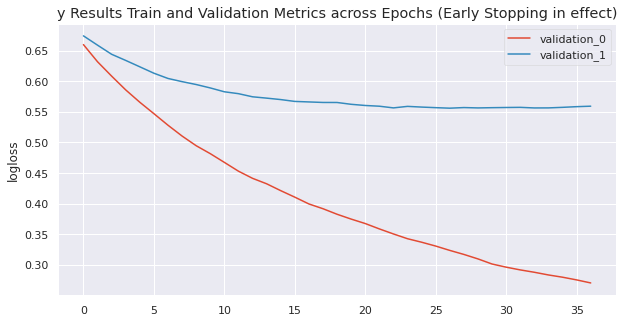

    Time taken for this Target (in seconds) = 862
    Binning_Flag set to False or there are no float vars in data set to be binned
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
     Actual Training time taken in seconds = 15
Training of models completed. Now starting predictions on test data...
    Making test Data predictions using modified Threshold = 0.058
    Calculating weighted average ensemble of 5 classifiers
Error: Sample submission file is incorrect. Please check it. continuing...
    Plotting Feature Importances to explain the output of model
Trying to plot SHAP values if SHAP is installed in this machine...


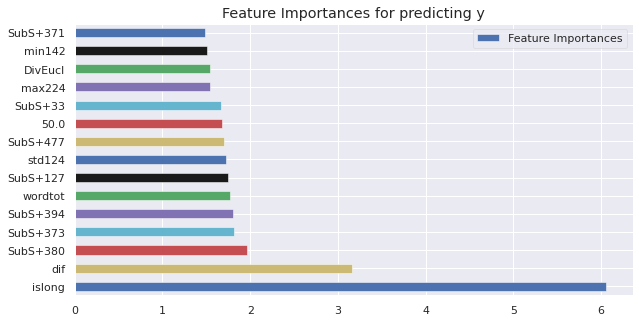

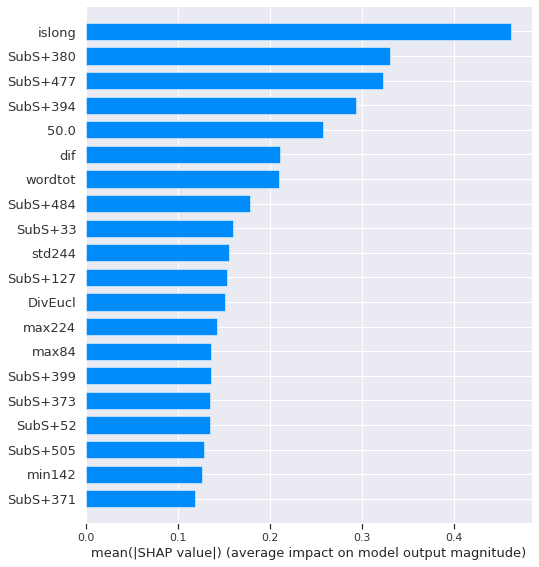

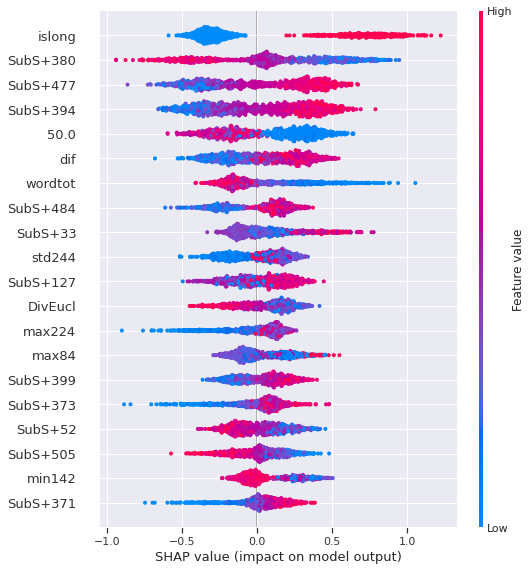

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 890
Writing Output files to disk...
    Saving predictions to ./y/y_Binary_Classification_test_modified.csv
    Saving predictions to ./y/y_Binary_Classification_submission.csv
    Error: Not able to save submission file. Skipping...
    Saving predictions to ./y/y_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 14.9 for the Entire Process


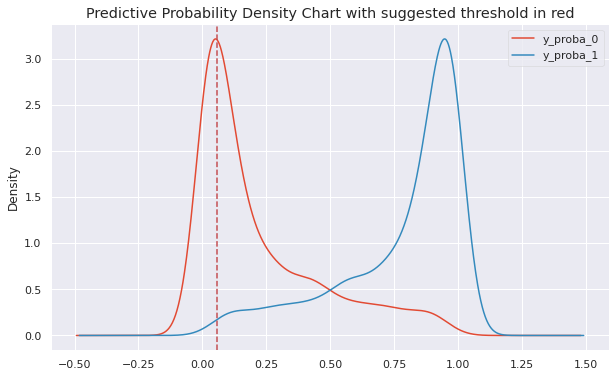

In [ ]:
model, features, trainm, testm = Auto_ViML(
    train=df_auto_scikit.iloc[train_indx],
    target="y",
    test=df_auto_scikit.iloc[test_indx],
    sample_submission=None,
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="balanced_accuracy",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=False,
    Imbalanced_Flag=False,
    verbose=2,
)

In [ ]:
# Print model selected by the auto selector
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=26, gpu_id=0,
              grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.09518162193353041,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=-999, monotone_constraints='()', n_estimators=352,
              n_jobs=-1, nthread=-1, num_parallel_tree=1,
              predictor='cpu_predictor', random_state=1, reg_alpha=0.5,
              reg_lambda=0.5, scale_pos_weight=1, seed=1, subsample=0.7,
              tree_method='hist', updater='grow_colmaker', ...)

## Riemannian Geometry

https://github.com/alexandrebarachant/bci-challenge-ner-2015 : We used the parameters listed here for our solution. We verified the choice of parameter with a GridSearch.

In [ ]:
!pip install pyriemann --quiet

     |████████████████████████████████| 51kB 3.7MB/s 


Warning : you have to comment the line 5 for complicated reasons in pyriemann.

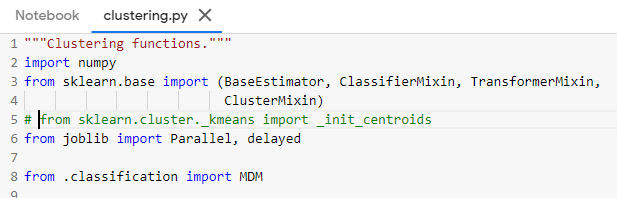

In [ ]:
# WARNING : You have to comment import kmeans in the Scikit folder....
# Incompatibility between the 2 packages...
import pyriemann 
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances
from pyriemann.channelselection import ElectrodeSelection

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

X = filtered_epochs # your EEG data, in format Ntrials x Nchannels X Nsamples
y = infos[0] # the labels

pipe_rie = make_pipeline(
    pyriemann.estimation.XdawnCovariances(nfilter=5, applyfilters=True),
    ElectrodeSelection(nelec=35, metric='riemann'),
    TSclassifier(metric='riemann', tsupdate=False))

param_grid = {
     # 'xdawncovariances__xdawn_estimator': ['lwf', 'oas', 'scm'],
    'tsclassifier__clf' : [LogisticRegressionCV()],
    'tsclassifier__metric' : ["logeuclid"]
}


cv = GroupKFold(n_splits=5).split(X, y, groups=groups)
# NB : cannot use scoring = AUC because of annoying bug
search = GridSearchCV(pipe_rie, param_grid, n_jobs=-1, 
                      scoring=None, verbose=3, cv=cv)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameter (CV score=0.718):
{'tsclassifier__clf': LogisticRegressionCV(), 'tsclassifier__metric': 'logeuclid'}


In [ ]:
cv = GroupKFold(n_splits=5).split(X, y, groups=groups)
for train_index, test_index in cv:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    display(pretty_results(X_train, X_test, y_train, y_test, search))

train test
class_balance  0.74 0.60
accuracy       0.80 0.71
AUC            0.83 0.79

train test
class_balance  0.72 0.68
accuracy       0.79 0.73
AUC            0.83 0.77

train test
class_balance  0.72 0.66
accuracy       0.78 0.75
AUC            0.82 0.82

train test
class_balance  0.68 0.81
accuracy       0.76 0.84
AUC            0.81 0.84

train test
class_balance  0.68 0.83
accuracy       0.76 0.86
AUC            0.81 0.85

## Submission

In [ ]:
# Scikit usual pipeline
X_final_test = subsample_and_concat(filtered_test_epochs, test_meta_cor, psd_test_epochs)
SampleSubmission.loc[:, "classic"] = pipe.predict_proba(X_final_test)[:, 1]

# Auto-scikit
# SampleSubmission.loc[:, "auto"] = model.predict_proba(df_auto_scikit_test[features])[:, 1]

# Riemann
# SampleSubmission.loc[:, "riemann"] = pipe_rie.predict_proba(test_epochs)[:, 1]
SampleSubmission.loc[:, "riemann"] = search.predict_proba(test_epochs)[:, 1]

# Bagging
a = 0.6
pred = a*SampleSubmission["riemann"] + (1-a)*SampleSubmission["classic"]
# pred = SampleSubmission["riemann"]
# pred = SampleSubmission["classic"]

def submit_and_evaluate(pred):
    print("mean prediction", np.mean(pred))
    SampleSubmission.Prediction = pred
    SampleSubmission.iloc[:, [0, 1]].to_csv("Submission.csv", index=0)
    SampleSubmission.loc[:, "true"] = true_labels[0]

    print("Secret Val AUC", roc_auc_score(true_labels[0], pred))

submit_and_evaluate(pred)

mean prediction 0.6869394141182543
Secret Val AUC 0.7696075327146938


Best :
- 0.69 Classic Scikit
- 0.754 Riemann

Bagged : 
- 0.778 a = 0.6


Congratulation : We produced a top 3 submission of a Kaggle Challenge !

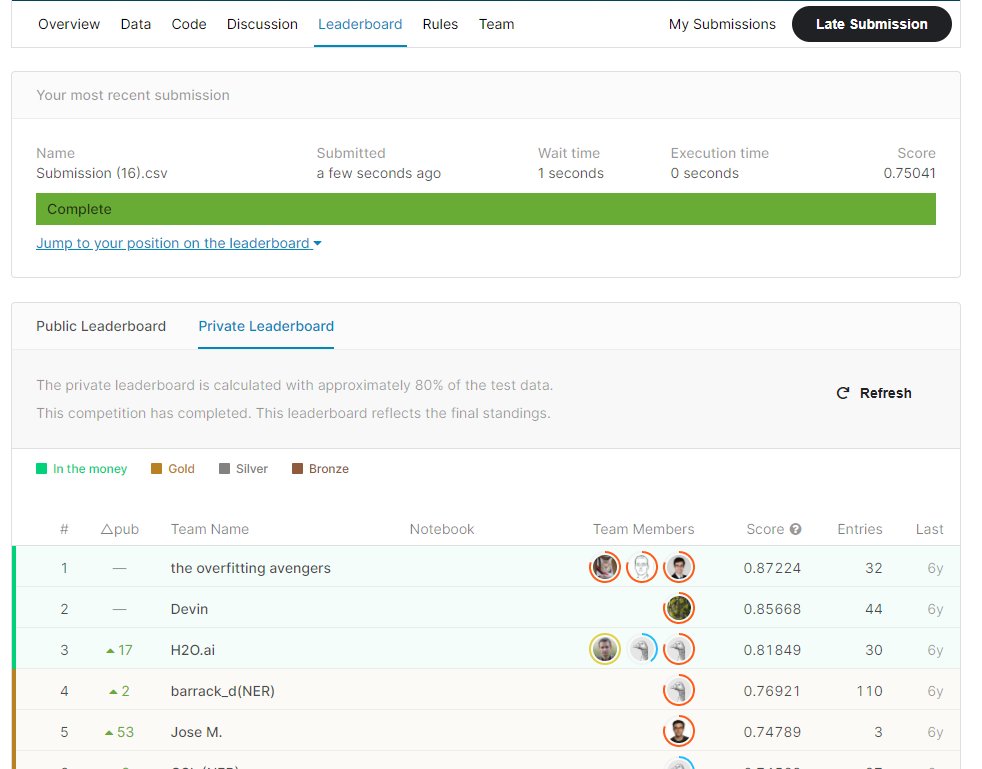

## Bonus : Study subject by subject

In [ ]:
SampleSubmission

IdFeedBack  Prediction  classic  riemann  true groups    sess  \
0     S01_Sess01_FB001        0.66     0.61     0.69     1    S01  Sess01   
1     S01_Sess01_FB002        0.79     0.78     0.80     1    S01  Sess01   
2     S01_Sess01_FB003        0.57     0.54     0.59     0    S01  Sess01   
3     S01_Sess01_FB004        0.66     0.79     0.58     1    S01  Sess01   
4     S01_Sess01_FB005        0.71     0.82     0.63     0    S01  Sess01   
...                ...         ...      ...      ...   ...    ...     ...   
3395  S25_Sess05_FB096        0.79     0.69     0.86     1    S25  Sess05   
3396  S25_Sess05_FB097        0.66     0.53     0.74     0    S25  Sess05   
3397  S25_Sess05_FB098        0.68     0.61     0.72     1    S25  Sess05   
3398  S25_Sess05_FB099        0.73     0.50     0.88     1    S25  Sess05   
3399  S25_Sess05_FB100        0.55     0.55     0.55     1    S25  Sess05   

      session  feedback  
0           1         1  
1           1         2  
2           1         3  
3           1         4  
4           1         5  
...       ...       ...  
3395        5        96  
3396        5        97  
3397        5        98  
3398        5        99  
3399        5       100  

[3400 rows x 9 columns]

In [ ]:
def auc_group(df):
    y_hat = df.Prediction
    y = df.true
    return roc_auc_score(y, y_hat)

SampleSubmission.loc[:, "groups"] = SampleSubmission.IdFeedBack.apply(lambda x: x[:3])
SampleSubmission.loc[:, "session"] = SampleSubmission.IdFeedBack.apply(lambda x: int(x[8:10]))
SampleSubmission.loc[:, "feedback"] = SampleSubmission.IdFeedBack.apply(lambda x: int(x[13:]))
bonus = SampleSubmission.groupby(["groups"]).apply(auc_group)
bonus = pd.DataFrame(bonus, columns=["auc"])
bonus.loc[:, "ratio"] = SampleSubmission.groupby(["groups"]).true.mean()
bonus

auc  ratio
groups            
S01    0.72   0.80
S03    0.77   0.41
S04    0.88   0.80
S05    0.66   0.42
S08    0.76   0.72
S09    0.76   0.84
S10    0.85   0.91
S15    0.89   0.94
S19    0.73   0.66
S25    0.69   0.58

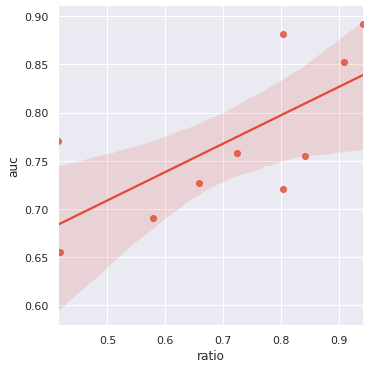

In [ ]:
sns.lmplot(x="ratio", y="auc", data=bonus);

We can see on the plot above that the more the ratio of the number of positive / negative feedback increases, the more our predictive model has a good AUC.

This means that people who are already correctly interpreted by the BCI will subsequently also be interpreted correctly by our error correction system, while people who are misinterpreted by the primary letter recognition system, will also be misinterpreted by our secondary error correction system.

In [ ]:
bonus = SampleSubmission.groupby(["groups", "session"]).apply(auc_group)
bonus = pd.DataFrame(bonus, columns=["auc"])
bonus.loc[:, "ratio"] = SampleSubmission.groupby(["groups", "session"]).true.mean()
bonus

auc  ratio
groups session            
S01    1       0.77   0.83
       2       0.83   0.82
       3       0.77   0.75
       4       0.73   0.82
       5       0.59   0.80
S03    1       0.90   0.52
       2       0.84   0.50
       3       0.66   0.33
       4       0.80   0.40
       5       0.66   0.36
S04    1       0.81   0.87
       2       0.96   0.88
       3       0.86   0.77
       4       0.82   0.83
       5       0.89   0.72
S05    1       0.65   0.42
       2       0.72   0.57
       3       0.55   0.47
       4       0.59   0.40
       5       0.71   0.31
S08    1       0.80   0.77
       2       0.95   0.80
       3       0.74   0.75
       4       0.81   0.70
       5       0.62   0.65
S09    1       0.65   0.88
       2       0.82   0.80
       3       0.70   0.82
       4       0.80   0.95
       5       0.78   0.79
S10    1       0.80   0.88
       2       0.96   0.92
       3       0.69   0.92
       4       1.00   0.97
       5       0.86   0.88
S15    1       1.00   0.97
       2       0.97   0.97
       3       0.90   0.95
       4       0.99   0.93
       5       0.81   0.91
S19    1       0.79   0.73
       2       0.63   0.75
       3       0.80   0.72
       4       0.73   0.63
       5       0.73   0.54
S25    1       0.79   0.70
       2       0.79   0.72
       3       0.59   0.43
       4       0.73   0.53
       5       0.60   0.54

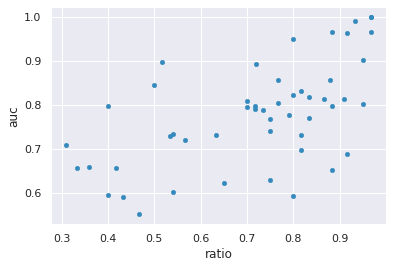

In [ ]:
bonus.plot.scatter(x='ratio', y='auc');

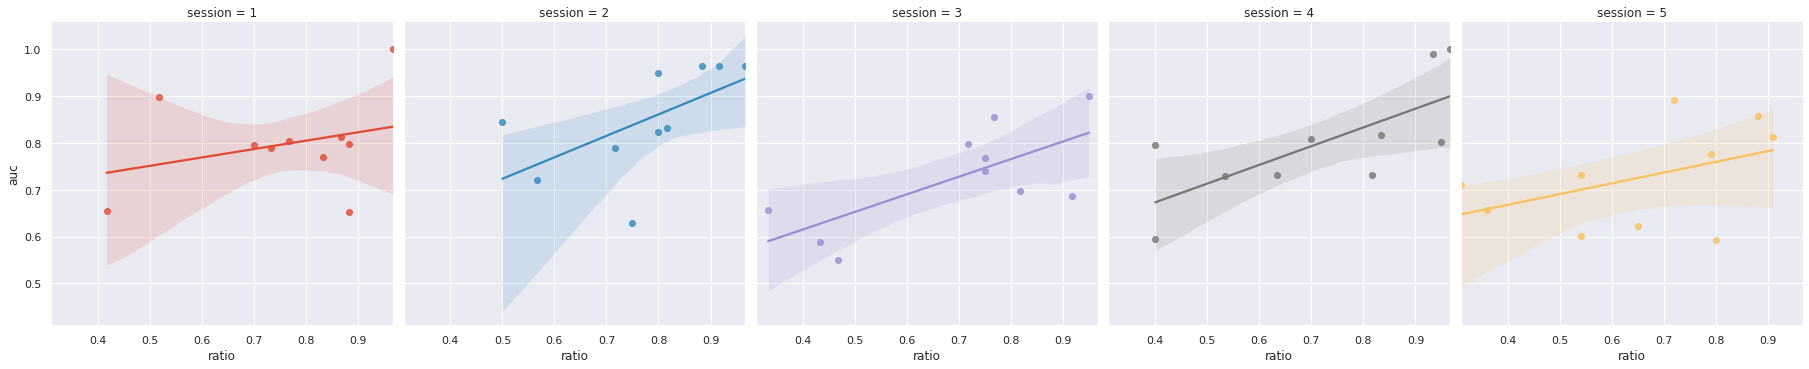

In [ ]:
import seaborn as sns
sns.lmplot(x="ratio", y="auc", hue="session", col="session", data=bonus.reset_index());

In [ ]:
bonus.reset_index().loc[:]

We have written in our report: "and so the FRN would only appear at the beginning of the experiment for these people." : But nothing is really significative here.